#### 라이브러리 불러오기

In [1]:
import os

import numpy as np
import pandas as pd
from datetime import datetime

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

2023-08-30 10:24:44.170159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 데이터 불러오기

In [7]:
_PATH_BASE = os.path.join(os.getcwd(), 'data')
_PATH_TRAIN = os.path.join(_PATH_BASE, 'climate_train.csv')
_PATH_VALID = os.path.join(_PATH_BASE, 'climate_valid.csv')
_PATH_TEST = os.path.join(_PATH_BASE, 'climate_test.csv')

try:
    df_train = pd.read_csv(_PATH_TRAIN)
    df_valid = pd.read_csv(_PATH_VALID)
    df_test = pd.read_csv(_PATH_TEST)
except Exception as e:
    print('훈련/검증/시험파일이 존재하지 않습니다.\n'
          '52-ts-climate-pp.ipynb 실행 후 작업하시기 바랍니다.')
    print(e)

In [66]:
column_indices = {
    name: i for i, name in enumerate(df_train.columns)
}

: 

#### 윈도우 생성 클래스 정의

In [55]:
class WindowGen():
    
    def __init__(
        self,
        input_width, 
        label_width, 
        shift,
        df_train = df_train,
        df_valid = df_valid,
        df_test = df_test,
        label_columns = None
    ):
        
        self.df_train = df_train
        self.df_valid = df_valid
        self.df_test = df_test
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {
            name: i for i, name in enumerate(df_train.columns)
        }
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = \
            np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = \
            np.arange(self.total_window_size)[self.label_slice]
            
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
        
    def sample_gen(self, start=0):
        start = min(start, self.df_train.shape[0]-300)
        return tf.stack([
            np.array(self.df_train[start:start+self.total_window_size]),
            np.array(self.df_train[start+100:start+100+self.total_window_size]),
            np.array(self.df_train[start+200:start+200+self.total_window_size])
        ])
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.label_slice, :]
        
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]] 
                        for name in self.label_columns
                ],
                axis=-1
            )
        
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='T (degC)', max_subplots=3, start=0):
        inputs, labels = self.split_window(self.sample_gen(start))
        
        plt.figure(figsize=(12, 12))
        
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label='Inputs',
                marker='.',
                zorder=-10
            )
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
                
            if label_col_index is None:
                continue
            
            plt.scatter(
                self.label_indices,
                labels[n, :, label_col_index],
                edgecolors='k',
                label='Labels',
                c='#2ca02c',
                s=64
            )
            
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker='X',
                    edgecolors='k',
                    label='Predictions',
                    c='#ff7f0e',
                    s=64
                )
                
            if n == 0:
                plt.legend()
        
        plt.xlabel('Time [h]')
        plt.show()
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )
        
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.df_train)
    
    @property
    def valid(self):
        return self.make_dataset(self.df_valid)
    
    @property
    def test(self):
        return self.make_dataset(self.df_test)
    
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

In [56]:
# 생성 테스트
w1 = WindowGen(
    input_width=24, label_width=1, shift=24, label_columns=['T (degC)']
)
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [57]:
w2 = WindowGen(
    input_width=6, label_width=1, shift=1, label_columns=['T (degC)']
)
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

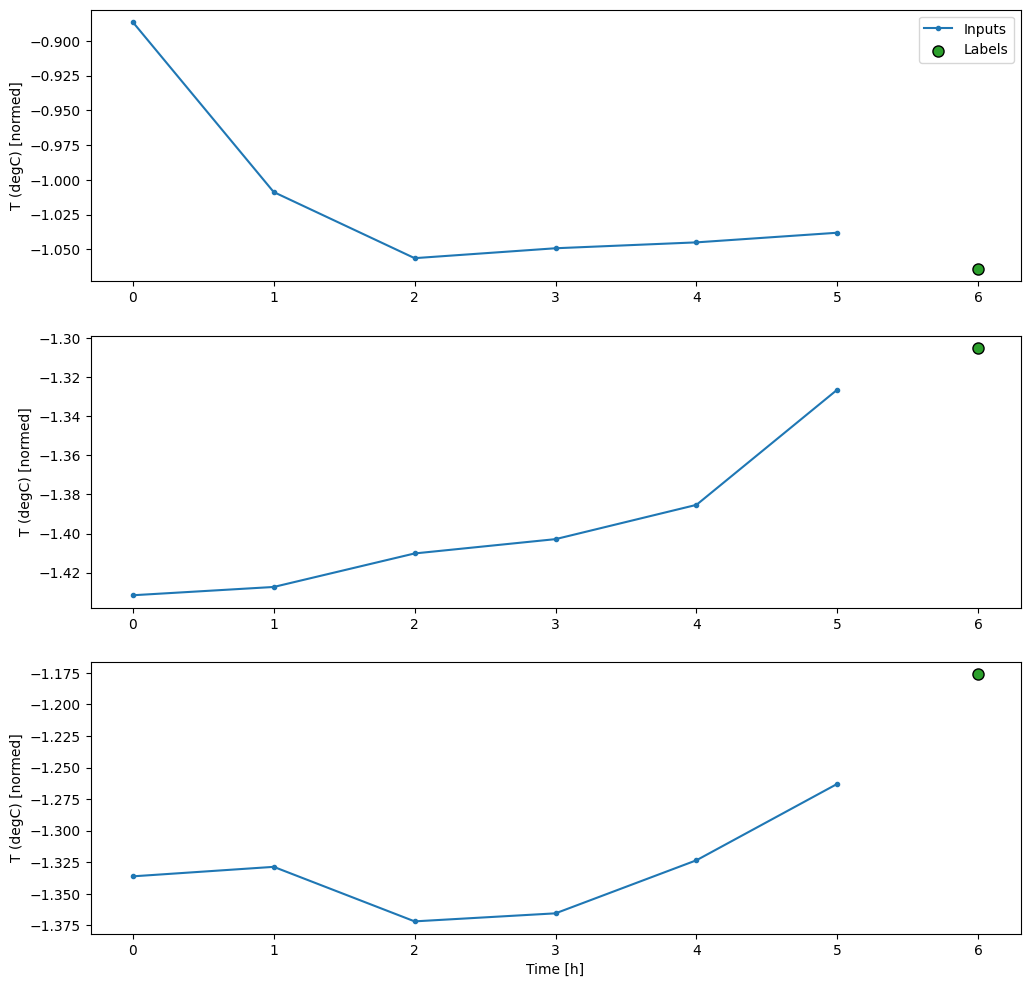

In [58]:
w2.plot(start=1000)

In [59]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [62]:
for _inputs, _labels in w2.train.take(1):
    print(f'Inputs shape(batch, time, features): {_inputs.shape}')
    print(f'Labels shape(batch, time, features): {_labels.shape}')
    print(f'w2.train size: {len(w2.train)}')

Inputs shape(batch, time, features): (32, 6, 19)
Labels shape(batch, time, features): (32, 1, 1)
w2.train size: 1534
